In [3]:
# BiocManager::install("philr")
# BiocManager::install("phyloseq")
# BiocManager::install("microbiome")
# install.packages("RColorBrewer")
# install.packages("UpSetR")
# install.packages("ggfortify")
# install.packages("randomForest")
# install.packages("rfUtilities")
# install.packages("phytools")
# install.packages("gridExtra")
# install.packages("remotes")
# install.packages('devtools')
# install.packages("intergraph")
# devtools::install_github('reptalex/phylofactor')
# devtools::install_github("briatte/ggnet")
# remotes::install_github("vmikk/metagMisc")
# remotes::install_github("pmartinezarbizu/pairwiseAdonis/pairwiseAdonis")
# remotes::install_github("gauravsk/ranacapa")

In [4]:
library(philr, warn.conflicts = F, quietly = T)
library(RColorBrewer, warn.conflicts = F, quietly = T)
library(UpSetR, warn.conflicts = F, quietly = T)
library(ggfortify, warn.conflicts = F, quietly = T)
library(randomForest, warn.conflicts = F, quietly = T)
library(rfUtilities, warn.conflicts = F, quietly = T)
library(phytools, warn.conflicts = F, quietly = T)
library(phyloseq, warn.conflicts = F, quietly = T)
library(gridExtra, warn.conflicts = F, quietly = T)
library(microbiome, warn.conflicts = F, quietly = T)
library(phylofactor, warn.conflicts = F, quietly = T)
library(dplyr, warn.conflicts = F, quietly = T)
library(pairwiseAdonis, warn.conflicts = F, quietly = T)
library(ape, warn.conflicts = F, quietly = T)
library(metagMisc, warn.conflicts = F, quietly = T)
library(ranacapa, warn.conflicts = F, quietly = T)
library(MASS, warn.conflicts = F, quietly = T)

In [5]:
seqtab <- read.table("sequence_table.merged.txt", header=T, row.names=1)
tax <- read.table("taxonomy_bac.txt", header=F, row.names=1, sep="\t")
tree <- read.tree("RAxML_bestTree.ref.tre")
tree.root <- midpoint.root(tree)

In [6]:
map <- read.table("../03-diff_abundance/map.txt", sep="\t", header=T, row.names=1)
notinmeta <- setdiff(row.names(seqtab), row.names(map))
notinraw <- setdiff(row.names(map), row.names(seqtab))
print("Samples found in ASV table but not in metadata:")
notinmeta
print("Samples found in metadata but not in sequencing table:")
notinraw

[1] "Samples found in ASV table but not in metadata:"


character(0)

[1] "Samples found in metadata but not in sequencing table:"


character(0)

In [7]:
ps.dat <- phyloseq(otu_table(seqtab, taxa_are_rows=F), sample_data(map), tax_table(as.matrix(tax)), tree.root)
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3270 taxa and 71 samples ]
sample_data() Sample Data:       [ 71 samples by 1 sample variables ]
tax_table()   Taxonomy Table:    [ 3270 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3270 tips and 3269 internal nodes ]

pdf 
  2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3270 taxa and 71 samples ]
sample_data() Sample Data:       [ 71 samples by 1 sample variables ]
tax_table()   Taxonomy Table:    [ 3270 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3270 tips and 3269 internal nodes ]

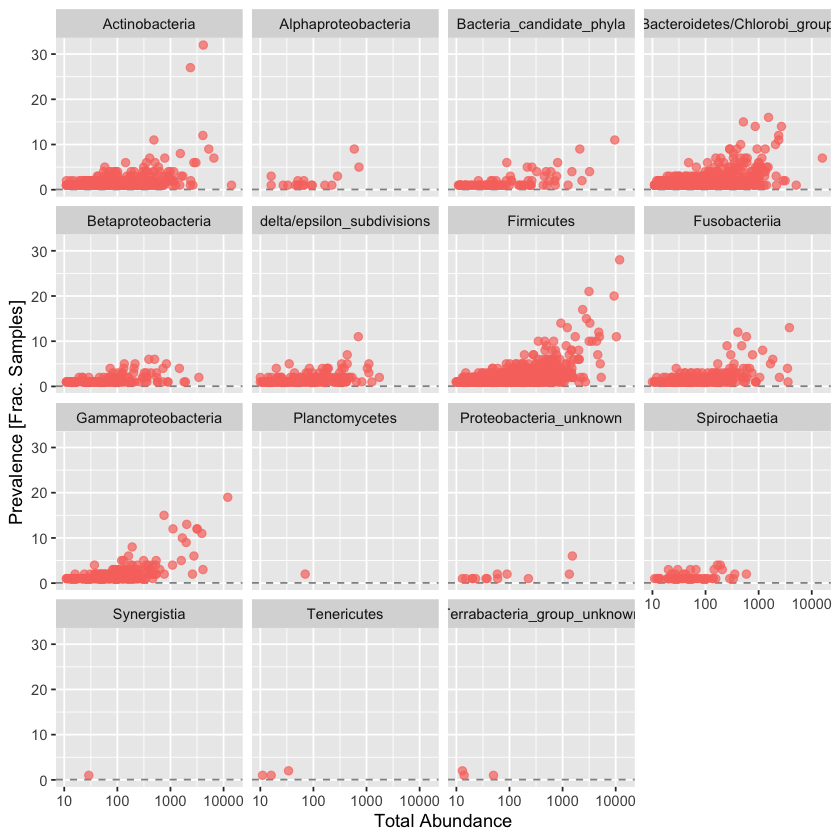

In [9]:
# compute prevalence dataframe
prevdf <- apply(X=otu_table(ps.dat), MARGIN=ifelse(taxa_are_rows(ps.dat), yes=1, no=2), FUN=function(x){sum(x>0)})
# add taxa and total read counts to dataframe
prevdf <- data.frame(Prevalence=prevdf, TotalAbundance=taxa_sums(ps.dat), tax_table(ps.dat))
# which phyla are comprised as mostly low prevalence ASVs?
lowprev <- ggplot(prevdf, aes(TotalAbundance, Prevalence, nsamples(ps.dat), color="V4")) + geom_hline(yintercept=0.05, alpha=0.5, linetype=2) + geom_point(size=2, alpha=0.7) + scale_x_log10() + xlab("Total Abundance") + ylab("Prevalence [Frac. Samples]") + facet_wrap(~V4) + theme(legend.position="none")
lowprev
pdf("totalabund_vs_prevalence.pdf")
lowprev
dev.off()
# kept asvs must be found in at least 1% of all samples 
ps.dat <- phyloseq_filter_prevalence(ps.dat, prev.trh=0.01)
ps.dat

In [10]:
# filter out samples with fewer than 1000 reads (based on ASV rareness, this shouldn't be an issue)
ps.dat <- prune_samples(sample_sums(ps.dat) > 1000, ps.dat)
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3270 taxa and 71 samples ]
sample_data() Sample Data:       [ 71 samples by 1 sample variables ]
tax_table()   Taxonomy Table:    [ 3270 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3270 tips and 3269 internal nodes ]

In [11]:
# write filtered tables to file
write.table(as.data.frame(otu_table(ps.dat)), "sequence_table.filt.txt", sep="\t", row.names=T, col.names=T)
# write filtered taxonomy to file
write.table(as.data.frame(tax_table(ps.dat)), "taxonomy_bac.filt.txt", sep="\t", row.names=T, col.names=T)
# filtered metadata
write.table(as.data.frame(sample_data(ps.dat)), "map.filt.txt", sep="\t", row.names=T, col.names=T)

In [12]:
# top phyla across samples (relative abundance data)
rel.abund <- transform_sample_counts(ps.dat, function(x) x/sum(x)) # get relative abundance
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[3]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V4 <- as.character(data$V4) # convert to character
data$V4[data$Abundance < 0.01] <- "< 1% abund" # rename low freq phyla
medians <- plyr::ddply(data, ~V4, function(x) c(median=median(x$Abundance)))
medians

V4,median
<chr>,<dbl>
< 1% abund,0.00000000
Actinobacteria,0.09880968
Alphaproteobacteria,0.02118989
Bacteria_candidate_phyla,0.04122582
Bacteroidetes/Chlorobi_group,0.21814970
Betaproteobacteria,0.03518910
delta/epsilon_subdivisions,0.03485191
Firmicutes,0.35506126
Fusobacteriia,0.06587112


In [13]:
# most common genera
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[8]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V8 <- as.character(data$V8) # convert to character
data$V8[data$Abundance < 0.20] <- "< 20% abund" # rename low freq phyla
medians <- plyr::ddply(data, ~V8, function(x) c(median=median(x$Abundance)))
medians

V8,median
<chr>,<dbl>
< 20% abund,0.0000000
Candidatus_Saccharibacteria_bacterium_oral_taxon_488_unknown,0.2181794
Cardiobacterium_valvarum,0.2519882
Corynebacterium,0.2174710
Flavobacteriaceae,0.3938660
Haemophilus_unknown,0.2278329
Lachnospiraceae_unknown,0.2374552
Lautropia_mirabilis,0.3711180
Porphyromonadaceae,0.3551041


pdf 
  2

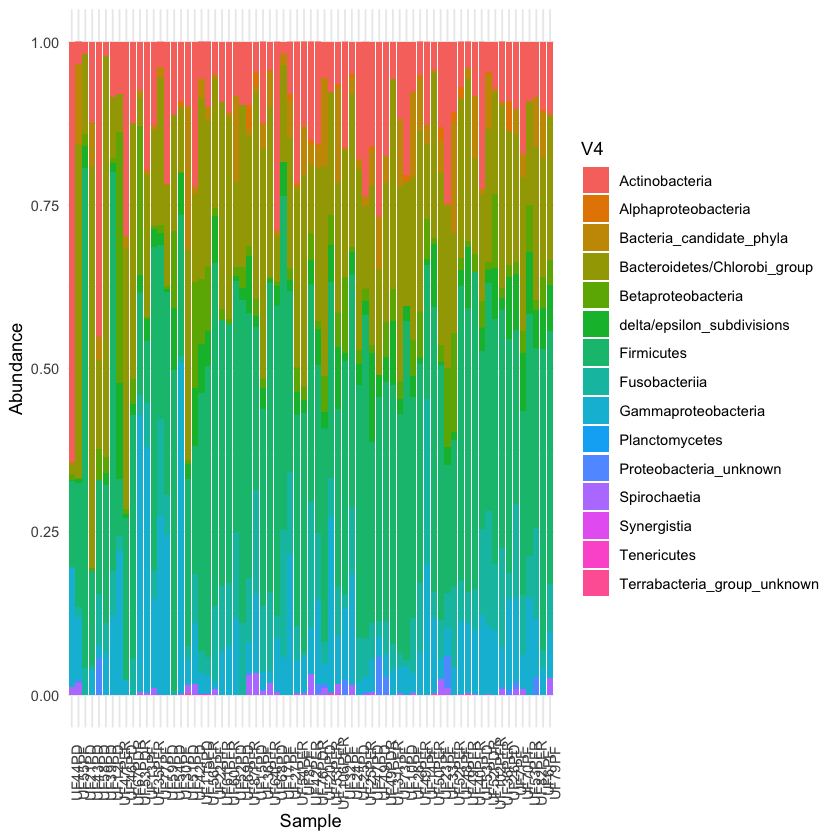

pdf 
  2

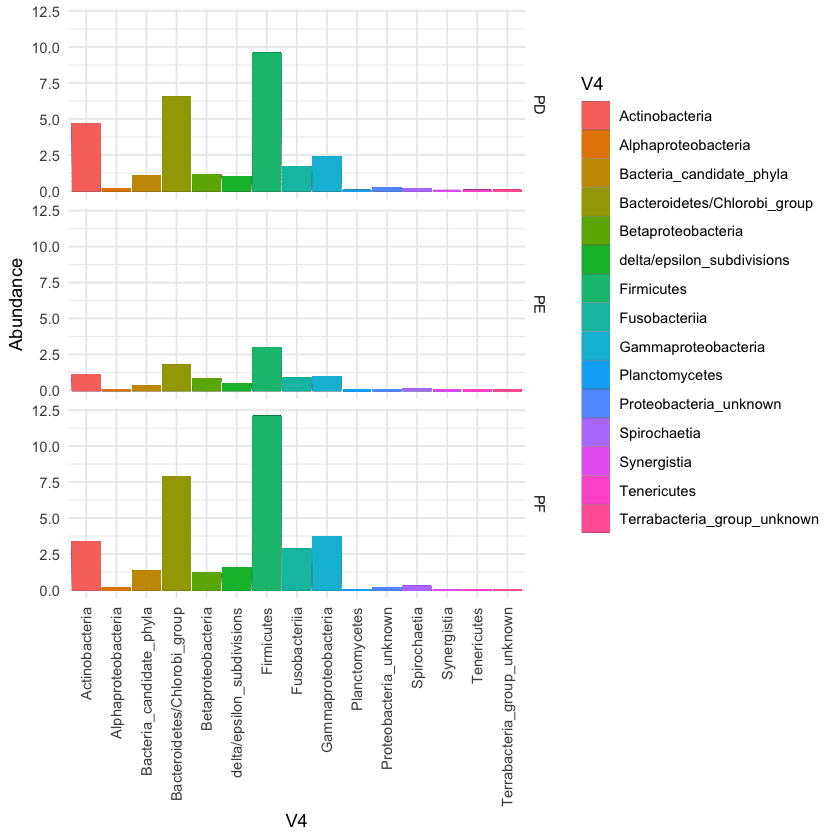

In [45]:
# phylum level figures
system("mkdir img")
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot by sample
taxbarsamp <- ggplot(data, aes(x=Sample, y=Abundance, fill=V4)) + geom_bar(aes(), stat="identity", position="stack") + theme_minimal() + theme(axis.text.x = element_text(angle = 90))
taxbarsamp
pdf("img/taxonomy_barchart.pdf")
taxbarsamp
dev.off()
# phyloseq group by tooth type
taxbargrp <- plot_bar(rel.abund, "V4", fill="V4", facet_grid="tooth_type") + geom_bar(aes(color=V4, fill=V4), stat="identity", position="stack")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
pdf("img/tax_bar.tooth_type_by_sample.pdf")
taxbargrp
dev.off()

pdf 
  2

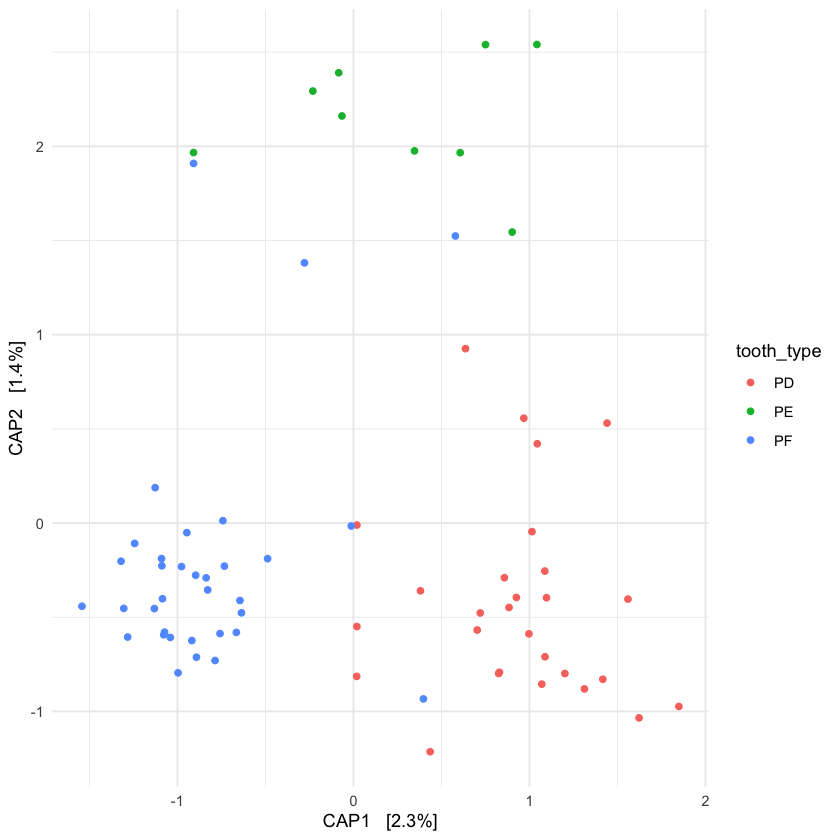

In [30]:
# distance based redundancy analysis
ordcap <- ordinate(ps.dat, "CAP", "bray", ~tooth_type)
# add dummy variable to sample data as plot_ordination cannot handle only one metadata column
sample_data(ps.dat)[ , 2] <- sample_data(ps.dat)[ ,1]
pdf("img/capscale_plt.tooth_type.pdf") 
plot_ordination(ps.dat, ordcap, color="tooth_type") + theme_minimal()
dev.off()
plot_ordination(ps.dat, ordcap, color="tooth_type") + theme_minimal()

In [22]:
# philr transform data and distance matrix to perform permanova statistics
philr.dat <- transform_sample_counts(ps.dat, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
is.rooted(phy_tree(philr.dat)) # check that tree is rooted
is.binary(phy_tree(philr.dat)) #check that multichotomies are resolved in tree
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
# distance matrix
philr.dist <- dist(philr.t, method="euclidean")

[1] TRUE

[1] TRUE

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...



In [34]:
# permanova test
metadata <- as(sample_data(philr.dat), "data.frame")
adonis2(philr.dist ~ tooth_type, data=metadata)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tooth_type,2,155.568,0.07333254,2.690616,0.001
Residual,68,1965.837,0.92666746,NA,NA
Total,70,2121.405,1.00000000,NA,NA



	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist, group =
phyloseq::sample_data(philr.dat)$tooth_type)

No. of Positive Eigenvalues: 70
No. of Negative Eigenvalues: 0

Average distance to median:
   PD    PE    PF 
4.838 5.985 4.556 

Eigenvalues for PCoA axes:
(Showing 8 of 70 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
231.24 166.20 136.25 120.69 102.14  86.46  80.54  71.39 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
          Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups     2  14.55  7.2750 1.6267    999  0.196
Residuals 68 304.12  4.4723                     

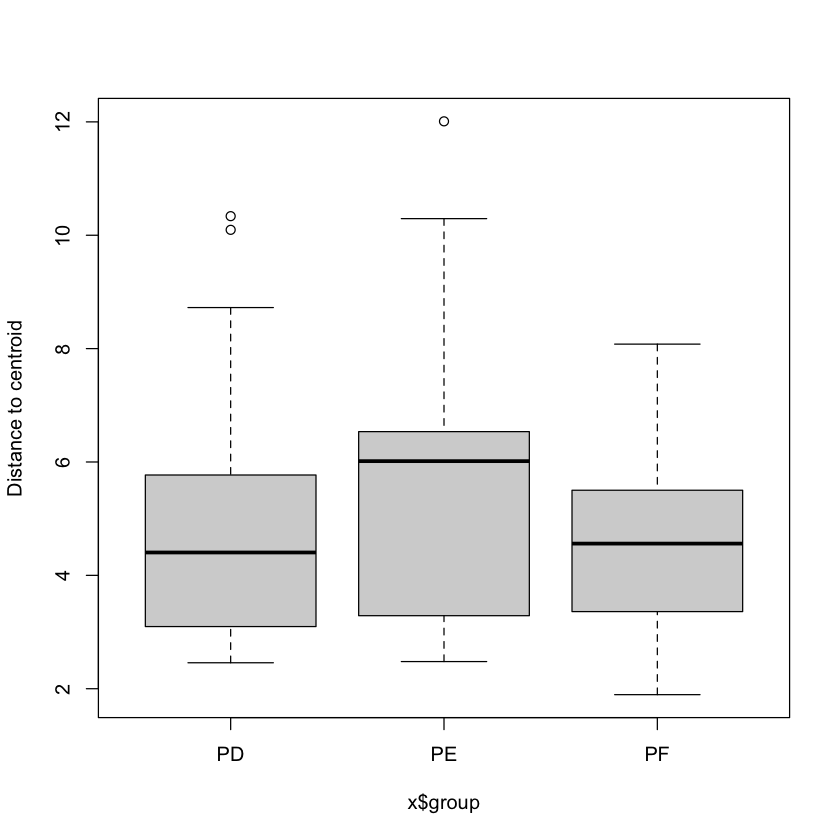

In [38]:
# beta dispersion test
dispr <- vegan::betadisper(philr.dist, phyloseq::sample_data(philr.dat)$tooth_type)
dispr
permutest(dispr)
boxplot(dispr)

pdf 
  2

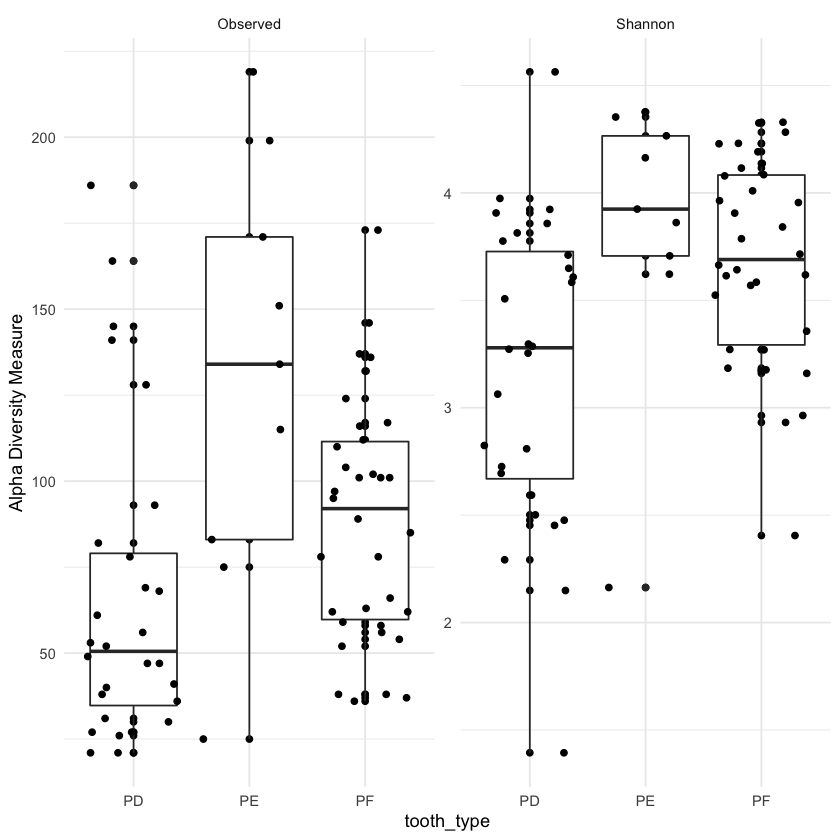

In [48]:
# alpha diversity
pdf("img/alpha_div.tooth_type.pdf")
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="tooth_type") + geom_boxplot() + theme_minimal() + geom_jitter()
dev.off()
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="tooth_type") + geom_boxplot() + theme_minimal() + geom_jitter()

In [47]:
# significance tests
wilcox.test(estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Observed, estimate_richness(subset_samples(ps.dat, tooth_type == "PE"))$Observed)
wilcox.test(estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Observed, estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Observed)
wilcox.test(estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Observed, estimate_richness(subset_samples(ps.dat, tooth_type == "PE"))$Observed)
wilcox.test(estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Shannon, estimate_richness(subset_samples(ps.dat, tooth_type == "PE"))$Shannon)
wilcox.test(estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Shannon, estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Shannon)
wilcox.test(estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Shannon, estimate_richness(subset_samples(ps.dat, tooth_type == "PE"))$Shannon)

Warning message in wilcox.test.default(estimate_richness(subset_samples(ps.dat, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Observed and estimate_richness(subset_samples(ps.dat, tooth_type == "PE"))$Observed
W = 52, p-value = 0.009259
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(estimate_richness(subset_samples(ps.dat, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Observed and estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Observed
W = 280.5, p-value = 0.005799
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(estimate_richness(subset_samples(ps.dat, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Observed and estimate_richness(subset_samples(ps.dat, tooth_type == "PE"))$Observed
W = 88, p-value = 0.05409
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Shannon and estimate_richness(subset_samples(ps.dat, tooth_type == "PE"))$Shannon
W = 53, p-value = 0.008477
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Shannon and estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Shannon
W = 269, p-value = 0.003034
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Shannon and estimate_richness(subset_samples(ps.dat, tooth_type == "PE"))$Shannon
W = 106, p-value = 0.1679
alternative hypothesis: true location shift is not equal to 0
